# Regression - The Basics

The quick and dirty of *regression*
- What it is
- Why it matters
- How to use it
- Advanced topics to be covererd in future tutorials 

## What is Regression?

3 definitions - for greater understanding

1. Wikipedia's definition, regression is a set of statistical processes for ***estimating***  the relationships among variables
2. Investopedia's definition, regression attempts to determine the strength of the ***relationship*** beween one dependant variable 
   and a series (one or more) of independant variables.
3. My definition, Regression is a form of data compression that is used to ***generalize*** the relationship between between features 
   in a dataset. Typically used to make some prediction on the value(s) of a ***continuous*** (1,2,3...) variable.

*Caveat* - There are regression techniques that handle binary discrete variables (T/F, 1/0, A/B...) but that will not be the focus of this tutorial

The keywords to this concept are:
- Estimating
- Relationship
- Generalize
- Continuous


## Why does this matter?

Regression is focused on the correlation between data points, and it can be a powerful way to make a *prediction* about what value a feature might have given other related data features.

For example, the **weight** and **size** of a person a generally highly correlated - so utilizing regression we could give an estimated size of a person based upon their given weight.

***THE BIG RULE***: You have likely heard the phrase, *correlation* is **not** *causation*

Basically what this means is that just because two items or features appear to have a relationship, regression cannot be used to establish causality.

![Maine+Margine](https://i1.wp.com/blogs.ams.org/blogonmathblogs/files/2017/04/Screen-Shot-2017-04-09-at-11.55.10-AM.png?resize=768%2C300&ssl=1)

Margine != Homewrecker



## How to use it! - Part 1, Pulling in the Data

In [1]:
# first lets load up pandas and pull down some data into a dataframe
import pandas as pd

#pull our data into a dataframe
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, 
                 names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration','model', 'origin', 'car_name'])

#Here is a quick correction to the data since the original source has a few ? values rather than  numbers
errors = df.query('horsepower=="?"').index
df = df.drop(errors)
df.horsepower = df.horsepower.astype('float64')


df.info() #basic metadata
df.describe() #basic statisical info on dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
model           392 non-null int64
origin          392 non-null int64
car_name        392 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Ok, so it looks like we have a cleaned data frame that includes the names of cars and several attributes associated with that given car

Though we can see that we obviously have values for MPG - lets assume for a minute that we had several cars that didn't have a value for MPG but we want to see if we can make a good estimate based upon other features such as horsepower, weight, acceleration, etc...

The first step before we try to make any predictions on our ***dependant variable*** (MPG) is to build a few visualizations so that we can better understand the association between MPG and other ***independant variables*** 


## How to use it, Part 2 - Visualizing and Assessing Features (variables)
 - Though pandas has a rich set of visualization functions that it can use by leverage components of matplotlib, we are going to utilize seaborn. Seaborn (sns) is great for building visualizations and comes with some 'opinionated' formating options that can sometimes be considered less daugnting that matplotlib's fig,ax paradigm.

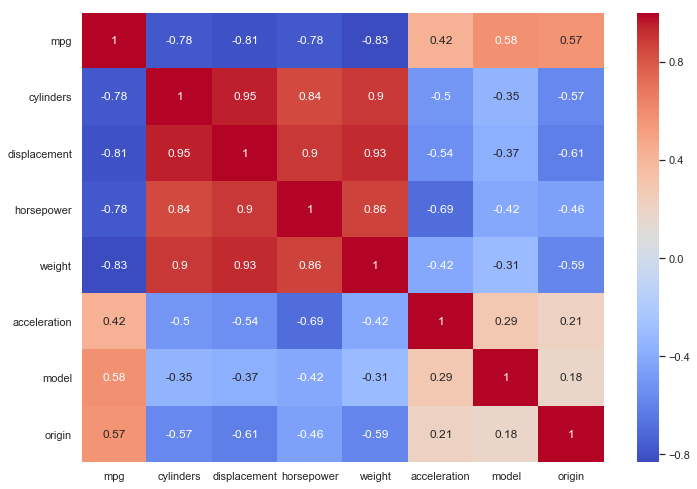

In [5]:
import seaborn as sns
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white', 'figure.figsize':(11.7,8.27)})

#lets start by making a simply heatmap to indicate to us which values may be correlated with MPG

sns.heatmap(df.corr(), cmap='coolwarm', annot=True) # calling the .corr() passes the dataframe as a correlation matrix to our heatmap visual

### WOWZERS, HECK OF A VISUAL FOR TWO LINES OF CODE!

Just by taking a quick look we can see the strongest correlations for MPG are cylinders, displacement, horsepower, and weight. The fact that they are negatively correlated makes sense since cars with powerful engines tend to consume more energy and be heavier (they have lower MPG). 

*Please note:* Cylinders, Displacement, Horsepower, & Weight also appear to be highly correlated with one another - this is is known as ***multicollinearity*** and in a multivariate regression model it may lead to overfitting. We won't worry about that is this tutorial but it is something to be mindful of; PCA can be one method employed to handle such situations, and for more on that please see my tutorial on PCA.

Lets take bit of a deeper look at the relationship between MPG, Cylinders, Displacement, Horsepower, & Weight with a pairplot (scatter matrix).

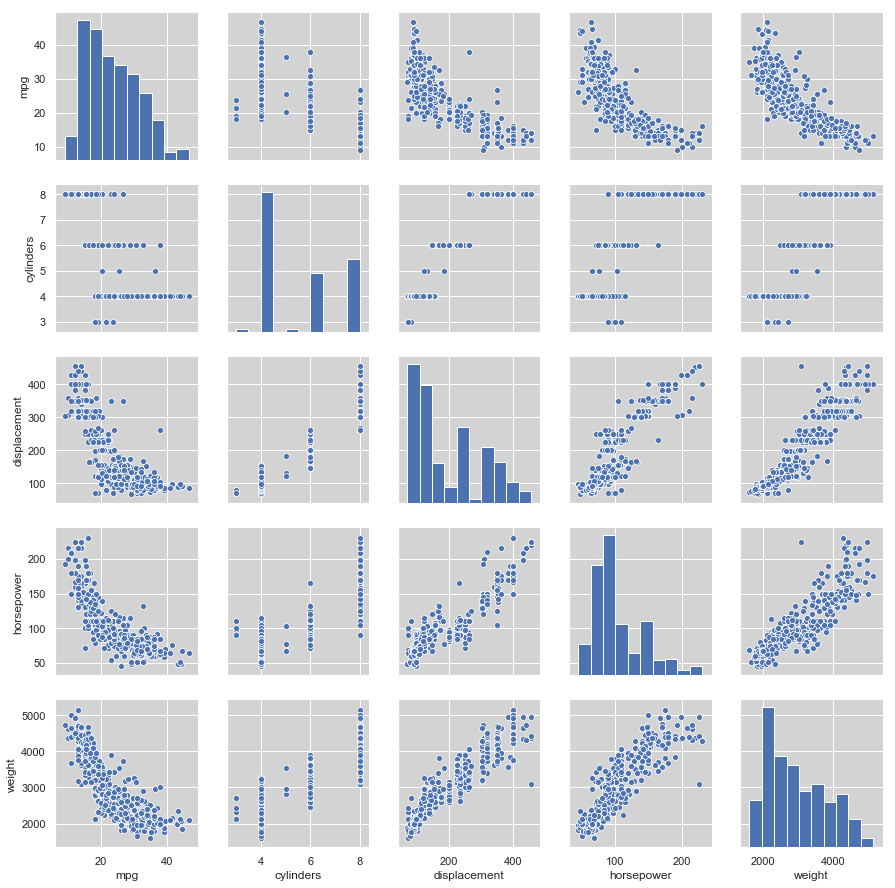

In [6]:
#Lets subset our dataframe to the features we would like to take a deeper look at
df2 = df[['mpg','cylinders', 'displacement', 'horsepower', 'weight']]

#Now lets build our pair plot to visualize the relationship of individual observations across several scattplots
sns.pairplot(df2)

# The Pair plot / Scatter Matrix is an extremely useful visual for quickly understanding the general relationship and distribution of 
# all of the variables within a DF - it gives you alot of great information.

## How to use it, Part 3 - Fitting Model & Predictions

Here we will demonstrate how to actually fit / use our model for predictions, so we'll need a test/train set to apply and test our model.

Typically there are other considerations when properly testing and implementing a model including the use of cross validation - these concepts will be demonstated and explained in more advanced tutorials. Here we'll be demonstrating the the fitting and use of a OLS (Ordinary Least Squares) based model.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# first lets seperate our dependant variable from our independant variables; .values converts DF & Series objects to numpy arrays
y = df2['mpg'].values
x = df2.drop('mpg',axis=1).values

# Do a test train split on our data, random_state ensures that we can replicate the split 
xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size = .3,random_state = 0) # Withold 30% of our values for testing

# lets fit our model up
model = LinearRegression() 
model.fit(xTrain, yTrain) 

# lets make our predictions!!!!
y_pred = model.predict(xTest)

# Now lets see how well our model predicted the values
compare = pd.DataFrame(data = {'predicted':y_pred, 'actual':yTest})

SyntaxError: invalid syntax (<ipython-input-38-d1af3b681eb6>, line 21)

In [61]:
# now lets generate some metrics to help us judge how well our model predicted our values

avg_actual = compare.agg({'actual':'mean'}).values


compare['sum of squares'] = (compare['actual'] - avg_actual) ** 2 # square the variance between each observation and the mean of observations
compare['squared errors'] = (compare['actual'] - compare['predicted']) ** 2  # square the variance between actual and predicted observations


# By taking the error and squaring it we make sure that we judge the variance between the actual value and the predicted value without worrying 
# about the direction of the variance. We can then use this number to determine other values

# SSE = A measure of how far off our model's predictions are from observed values
sse = compare['squared errors'].sum() # Sum of squared errors, the total amount of error 

# TSS = A measure of the amount of variance within a targeted variable
tss = compare['sum of squares'].sum() # total sum of squares, the total amount of variance between actuals and the mean of actuals

# R^2 = A measure of how much variance is captured by the model, Range for OLS is 0-1, with 1 meaning the model explains 100% of the variance
# Put another way, an R^2 of 1 for OLS regression would mean all observations are on the line of our model
r_squared = 1 - (sse/tss) # Equation for R-Squared, the coefficient of Detemination - how much 

print('R^2: '+str(round(r_squared,2)))


#for the stat nerds

# Degrees of freedom of our dependent variable when estimating the population variance
dft = xTest.shape[0] - 1

# Degrees of freedom for the the estimate of the underlying population error variance 
dfe = xTest.shape[0] - xTest.shape[1] -1

# Adjust R Squared, penalizes the use of additional features
r_squared_adj = 1 - (sse/dfe)/(tss/dft)

print('Adjusted R^2: '+str(round(r_squared_adj,2)))

# In OLS Regression, adding additional features will always drive a higher value  no matter the 'quality' of their contribution to the model.
# Adjusted R Squared compensates for this fact by penalizing our values based upon the number of features we've added
# this is very helpful for multivariate regression models

R^2: 0.68
Adjusted R^2: 0.67


In [63]:
# above is the underlying mathmatics of how to derive these scores, the same can be done by -

r_squared = model.score(xTest,yTest)
print('R^2: '+str(round(r_squared,2)))

R^2: 0.68


## COOL STORY BRO

You made it through the basics of regression - have a cool cat meme and some neat learning resources on me!

![Suspect](https://i1.wp.com/bestlifeonline.com/wp-content/uploads/2018/06/cat-meme-48.jpg?w=1024&ssl=1)

- StatQuest, [Fitting A Line AKA Linear Regression](https://youtu.be/PaFPbb66DxQ) > The Quick and Dirty
- StatQuest, [Linear Regression](https://youtu.be/nk2CQITm_eo) > More indepth - it covers most of the same topics in this tutorial